In [1]:
import music21
import keras
import numpy as np
import matplotlib.pyplot as plt
import random

from keras.layers import Input, Flatten, Dense, LSTM, Input, Embedding, Dropout, Concatenate, Reshape, GRU, LeakyReLU, BatchNormalization, Bidirectional, TimeDistributed
from keras.models import Model
from keras.layers.core import Lambda
from tensorflow.keras.optimizers import RMSprop, Adam

from music21 import *

import os
import tensorflow as tf

from keras import backend
from keras.constraints import Constraint

In [2]:
def one_hot(data_to_one_hot, features):
    #creates a zeros array with the size [trainsize of data, length of data sequence, number of features]
    one = np.zeros([data_to_one_hot.shape[0], data_to_one_hot.shape[1], features])
    for i in range(data_to_one_hot.shape[0]): 
        for j in range(data_to_one_hot.shape[1]):
            one[i][j][int(data_to_one_hot[i][j])] = 1 #re
    return one

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

def linear(x):
    return x

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [3]:
# get MuseScore environment
env = environment.Environment()
env['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore.exe'

In [4]:
notes = []
durations = []
paths = corpus.getComposer('bach')  #get all music from Bach


for file in paths:
    s = converter.parse(file) 
    for instr in s.parts:
        for element in instr.flat:
            if isinstance(element, note.Note):
                if element.isRest:
                    notes.append((element.name))
                    durations.append(element.duration.quarterLength)
                else:
                   notes.append((element.nameWithOctave))
                   durations.append(element.duration.quarterLength)

In [5]:
notes_set=sorted(set(notes))  #jede Note einmal und sortiert
durations_set=sorted(set(durations))  #jede Note einmal und sortiert

notes_dict = dict((element, number) for number, element in enumerate(notes_set)) 
durations_dict = dict((element, number) for number, element in enumerate(durations_set)) 

int_notes = dict((number, element) for number, element in enumerate(notes_set)) 
int_durations = dict((number, element) for number, element in enumerate(durations_set)) 


In [6]:
#dictionarys for notes and durations
int_notes_dict = dict((number, element) for number, element in enumerate(notes_set)) 
int_durations_dict = dict((number, element) for number, element in enumerate(durations_set)) 



In [7]:
int_notes = []
int_durations = []
for char in notes:
    int_notes.append(notes_dict[char])
for char in durations:
    int_durations.append(durations_dict[char])

In [8]:
#data windowing trough all notes/durations to get training data with the window-length in the shape of softmax-results
length = 16
stepwidth = 4
stop = len(int_notes) - length

a = 0
b = 80
#x_train_notes =  np.random.randint(a, b, (stop, length, len(notes_dict)))/200 # np.ones((stop, length, len(notes_dict)))
#x_train_durations =  np.random.randint(a, b,  (stop, length, len(durations_dict)))/200 #random.uniform(a, b) * np.ones((stop, length, len(durations_dict)))
x_train_notes =   np.zeros((stop, length, len(notes_dict)))
x_train_durations = np.zeros((stop, length, len(durations_dict)))
k=0

for i in np.arange(0,stop,stepwidth):
        sequence_notes=[int_notes[i:i+length]]
        sequence_durations=[int_durations[i:i+length]]
        for j in range(length):
            x_train_notes[k][j][sequence_notes[0][j]] = np.random.randint(120, 200, 1)/200
            x_train_durations[k][j][sequence_durations[0][j]] = np.random.randint(120, 200, 1)/200
            x_train_notes[k][j] = x_train_notes[k][j] / sum(x_train_notes[k][j])
            x_train_durations[k][j] = x_train_durations[k][j] / sum(x_train_durations[k][j])
            
            #x_train_notes[k][j][sequence_notes[0][j]] = 1
            #x_train_durations[k][j][sequence_durations[0][j]] = 1
        k = k+1


# Building discriminator

In [9]:
input_discriminator_notes = Input(shape = (length, len(notes_dict),))
input_discriminator_durations = Input(shape = (length, len(durations_dict),))

x1 = input_discriminator_notes
x1 = Dense(84, activation = 'relu')(x1)

x2 = input_discriminator_durations
x2 = Dense(12, activation = 'relu')(x2)

x =  Concatenate()([x1,x2])
x = LSTM(96, return_sequences=True)(x)
x = Dropout(rate=0.5)(x)
x = LSTM(48, return_sequences=True)(x)
x = Reshape([-1])(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(24, activation = 'relu')(x)

output = Dense(1, activation = 'sigmoid')(x) 

discriminator = Model([input_discriminator_notes, input_discriminator_durations],[output])
discriminator.compile(  loss = 'binary_crossentropy' , metrics = ['accuracy'], optimizer=RMSprop(lr=0.004))
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 84)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16, 12)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 16, 84)       7140        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 16, 12)       156         ['input_2[0][0]']                
                                                                                              

C:\Users\Fabian Fries\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


# Building Generator



In [10]:
noiselen = 10
embed_size = length

input_generator = Input(shape = (length, noiselen))



x = input_generator
x = TimeDistributed(Dense(20, activation = 'relu'))(x)
x = Dropout(rate = 0.7)(x)
#x = TimeDistributed(Dense(40, activation = 'relu'))(x)
#x = Dropout(rate = 0.7)(x)
#x = Dropout(rate=0.7)(x)


x1 = TimeDistributed(Dense(84, activation = 'relu'))(x)
x1 = Dropout(rate = 0.7)(x1)

x2 = TimeDistributed(Dense(24, activation = 'relu'))(x)
x2 = Dropout(rate=0.7)(x2)


notes = TimeDistributed(Dense(len(notes_dict), activation = 'softmax'))(x1) 
durations = TimeDistributed(Dense(len(durations_dict),  activation = 'softmax'))(x2)

generator = Model(input_generator, [notes, durations])
generator.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16, 10)]     0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 16, 20)      220         ['input_3[0][0]']                
 ted)                                                                                             
                                                                                                  
 dropout_2 (Dropout)            (None, 16, 20)       0           ['time_distributed[0][0]']       
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 16, 84)      1764        ['dropout_2[0][0]']        

# Model to train the generator

In [11]:
model_input = Input(shape = (length,noiselen,), name='model_input')

model_output = discriminator(generator(model_input))
model = Model(model_input, model_output)

model.compile( optimizer=RMSprop(lr=0.0005) , loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

xdat=[]
ydat1=[]
ydat2=[]
ydat3=[]
count=0

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 model_input (InputLayer)       [(None, 16, 10)]     0           []                               
                                                                                                  
 model_1 (Functional)           [(None, 16, 84),     9928        ['model_input[0][0]']            
                                 (None, 16, 12)]                                                  
                                                                                                  
 model (Functional)             (None, 1)            210801      ['model_1[0][0]',                
                                                                  'model_1[0][1]']                
                                                                                            

In [12]:
#music-pieces with few different notes have a high entropy
#to archive more variability in the results, the pieces with high entropy aren't used in training

from scipy.stats import entropy
x_train_notes1 = np.argmax(x_train_notes[0:25000], axis=2)
entr = entropy(x_train_notes1, axis=1)
print('Shape before entropy-delete:',x_train_notes1.shape)
print('Entropy vektor:', entr)
print('Max entropy:', max(entr))

x_train_notes1[np.argmax(entr)]

entrop = 2.65  #2.7 für length = 16  #3.4 für length = 16

a = [x for x, v in  enumerate(entr) if v>=entrop]
x_train_notes = x_train_notes[0:25000]
x_train_durations = x_train_durations[0:25000]

x_train_notes = np.delete(x_train_notes, a, axis=0)
x_train_durations = np.delete(x_train_durations, a, axis=0)
print('Shape after entropy-delete:', x_train_notes.shape)

Shape before entropy-delete: (25000, 16)
Entropy vektor: [2.55903082 2.48508242 2.4745022  ... 2.73518372 2.69982176 2.65767855]
Max entropy: 2.772588722239781
Shape after entropy-delete: (16566, 16, 84)


# Training

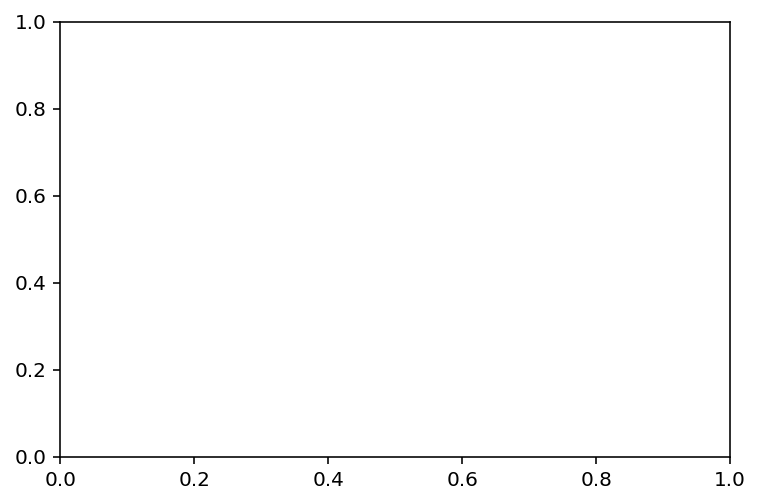

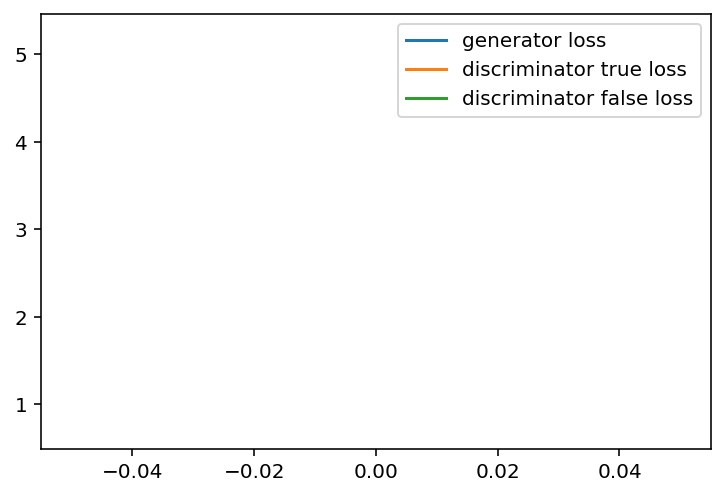

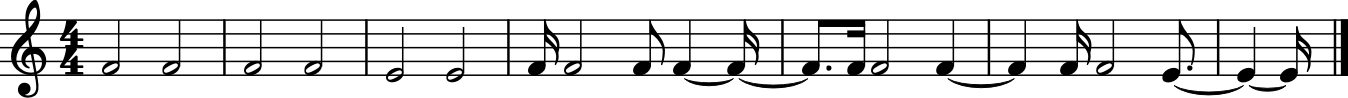

[[0.06542331 0.07656614 0.08222208 0.07534438 0.07821778 0.07223119
  0.0656511  0.06243278 0.06372035 0.07373974 0.06781057 0.06796759
  0.0674166  0.06417364 0.07817077 0.07037945 0.06941954 0.07772928
  0.07164744 0.06839747 0.07317332 0.07337832 0.07396334 0.07453783
  0.06196307]]


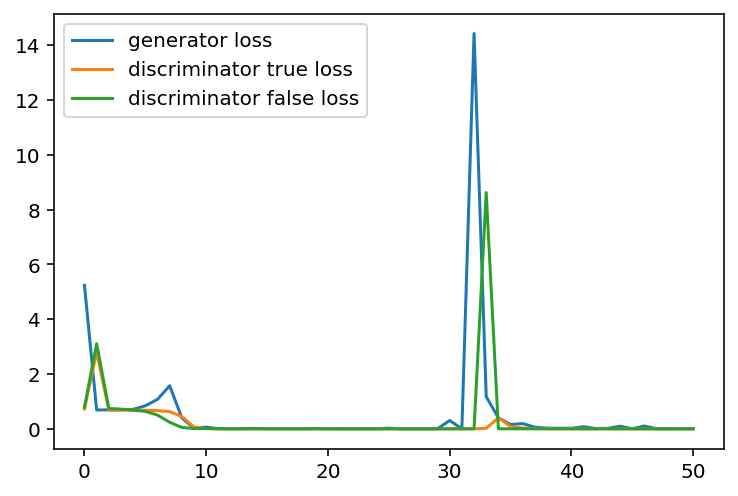

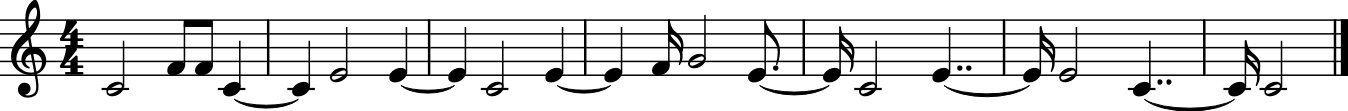

[[3.4420952e-06 3.9367049e-07 9.1002619e-08 7.7080585e-07 1.1922393e-06
  2.9060624e-07 1.8478967e-07 2.5289592e-07 1.2080624e-06 1.8163367e-06
  3.2286875e-06 5.8085135e-07 7.2753153e-07 1.3632268e-05 8.1543725e-08
  4.5064303e-07 3.7640604e-08 2.9903237e-07 1.4641796e-05 1.5982548e-07
  4.6000957e-07 2.3410063e-05 4.7155915e-08 8.0429551e-08 2.5298880e-06]]


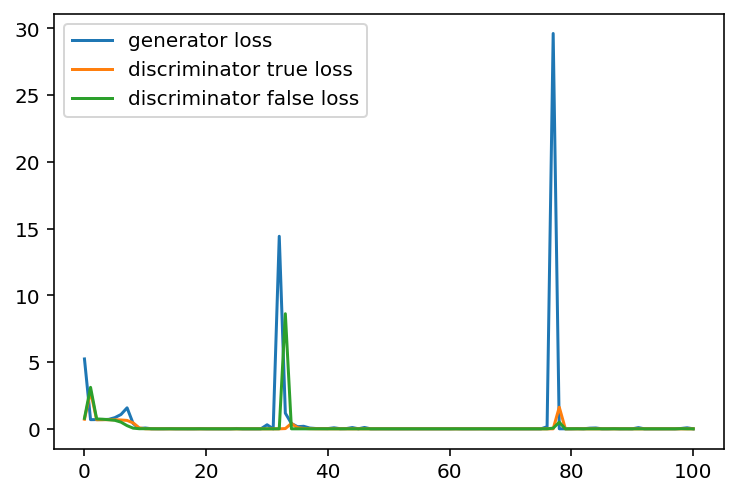

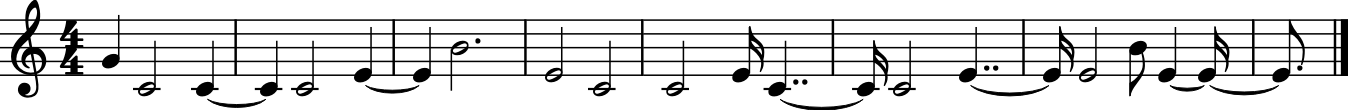

[[3.7061529e-10 3.4922498e-10 2.1456072e-10 2.6523395e-09 1.2295016e-09
  1.6425138e-10 5.9757056e-08 1.7354790e-10 1.6185918e-10 5.0046883e-10
  1.0337473e-10 3.9338183e-10 5.0109250e-10 7.5876960e-10 1.6271668e-09
  3.1213876e-10 6.6184724e-10 2.5508857e-09 1.5743453e-09 2.2990748e-10
  1.0665254e-10 8.8012149e-09 5.1720700e-10 7.9695878e-10 2.5303588e-09]]


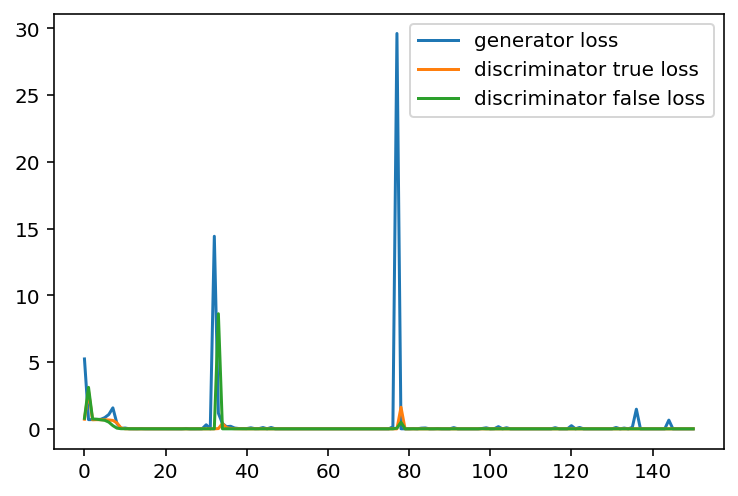

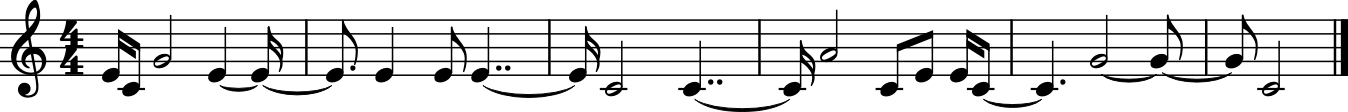

[[8.8786308e-22 9.8190330e-19 2.5287570e-20 4.5956297e-20 1.5000814e-19
  1.9774242e-19 6.8996961e-21 3.5465989e-19 2.0125347e-21 2.8721769e-20
  6.6609025e-16 1.4090032e-18 2.4901711e-19 3.7649190e-21 9.7251638e-20
  1.0885052e-21 2.1329648e-19 5.7036199e-21 7.6965584e-19 1.5376948e-19
  7.0541659e-20 1.4930821e-19 7.7766433e-22 1.6172661e-20 8.3768330e-21]]


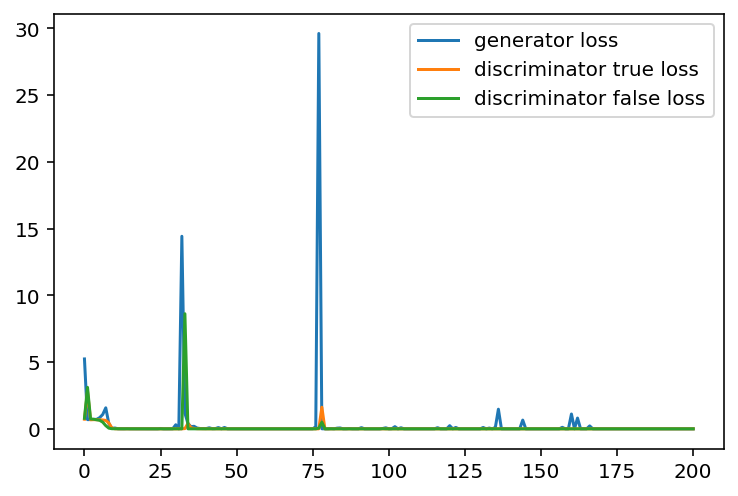

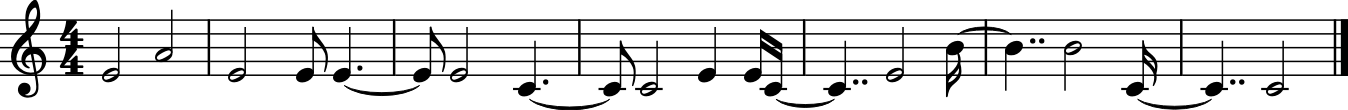

[[1.9874961e-20 1.5061783e-17 1.9776116e-20 1.2932934e-20 1.4527818e-18
  1.3025971e-12 1.0275406e-15 2.3274784e-19 2.4136474e-20 4.8218591e-20
  1.8573336e-20 1.1032126e-19 3.4581025e-20 1.0963035e-18 7.0675826e-19
  5.2256993e-20 8.5820667e-20 1.6930347e-17 1.5048538e-14 2.9616573e-18
  1.7143422e-20 1.9630227e-20 2.1467754e-20 2.6138904e-20 1.1969739e-18]]


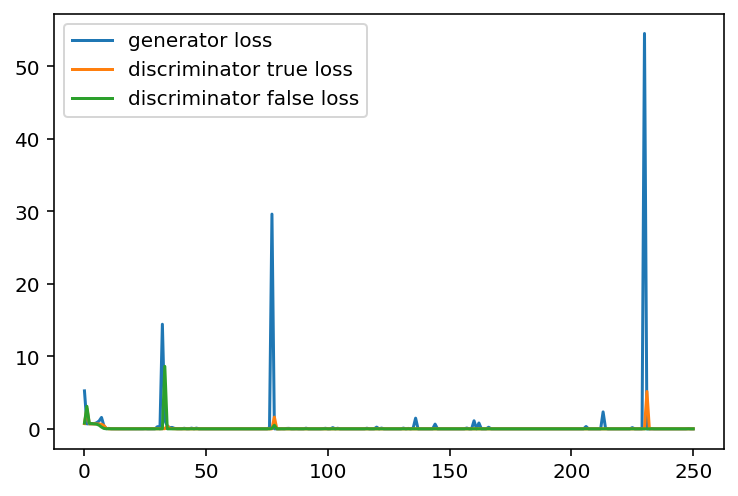

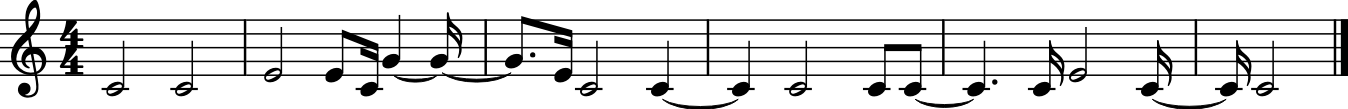

[[1.9671096e-07 5.4866181e-08 6.1630374e-07 4.7124138e-07 7.9458715e-08
  8.0727403e-08 1.0536010e-07 1.0521813e-07 1.4943845e-07 1.0045366e-07
  7.5005197e-08 2.9638684e-07 5.9251210e-08 5.0600755e-07 6.6705212e-07
  1.6849876e-07 1.2804048e-07 5.1419181e-07 1.4990120e-07 1.6662752e-07
  6.8561676e-06 2.0036761e-07 3.0940421e-07 8.5431502e-08 1.5087892e-07]]


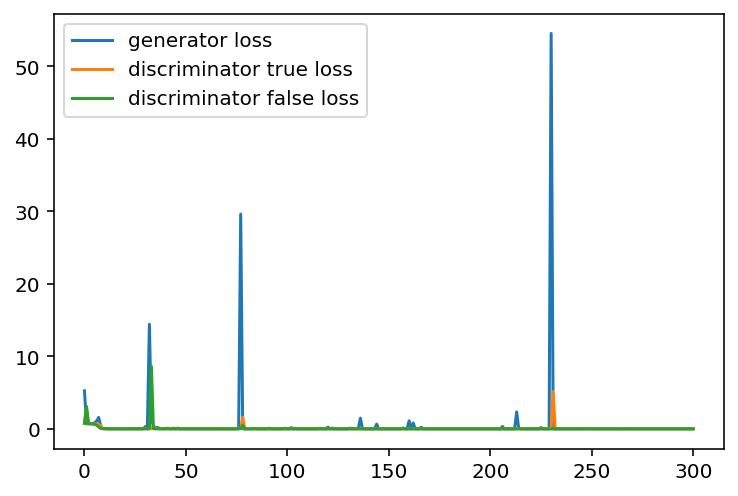

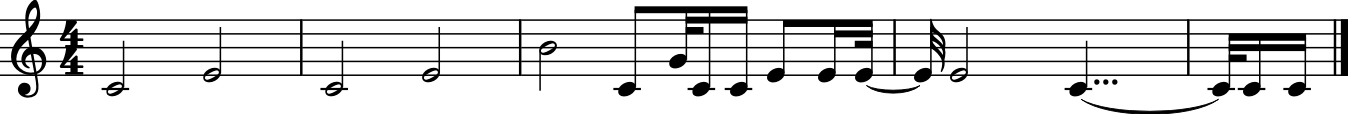

[[6.67347080e-11 8.01765529e-11 1.38556722e-10 1.20718557e-11
  4.24249073e-11 5.20233231e-11 1.09166322e-10 2.82328105e-10
  5.20632357e-11 3.89293493e-11 7.63884702e-12 8.54081996e-12
  6.92261526e-11 2.28892686e-11 1.86876990e-11 1.38048392e-10
  1.08550226e-11 5.78895057e-11 1.31421714e-11 1.35653835e-10
  1.30162435e-11 3.28825613e-11 1.48812421e-11 7.47796824e-11
  9.31579258e-10]]


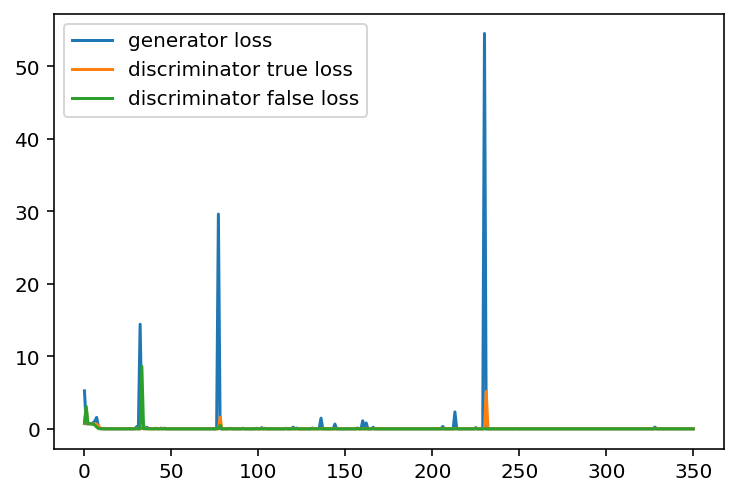

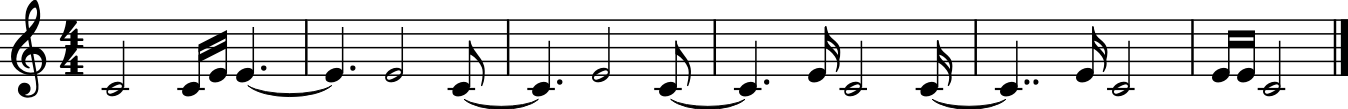

[[1.9445888e-15 3.2159297e-17 3.6090972e-17 3.4568966e-16 1.2742218e-16
  2.2710080e-17 2.1106609e-16 2.4890175e-15 1.8868596e-16 8.5887413e-14
  1.7653078e-15 3.9190881e-17 7.3146769e-16 1.9742915e-16 6.6524660e-14
  2.0966567e-17 6.7772880e-17 2.1394618e-17 1.2648166e-17 4.9153723e-18
  2.3934733e-15 3.8498578e-18 2.6560726e-15 3.2481720e-16 1.2103357e-17]]


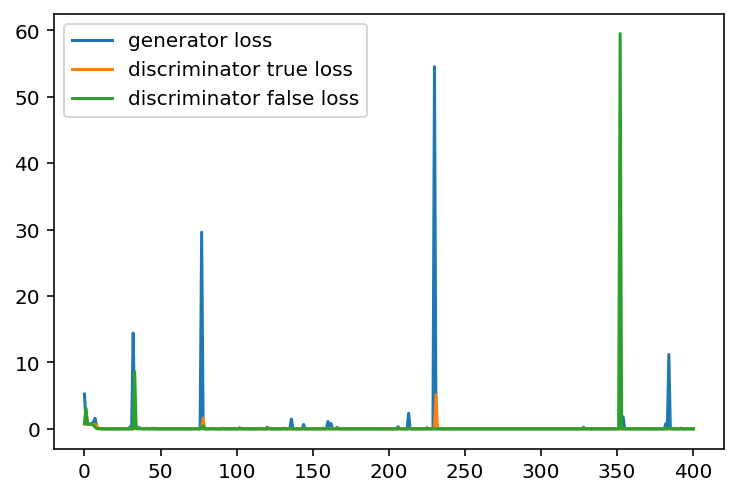

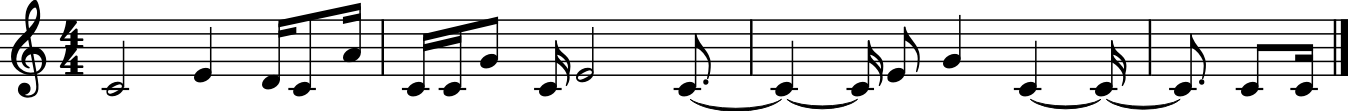

[[1.09676265e-20 1.14955373e-15 2.79206071e-21 1.05158841e-20
  6.02500466e-21 1.19461954e-19 2.26983409e-21 7.29838095e-21
  1.49618374e-19 3.38863430e-18 4.96373702e-20 2.11543066e-18
  8.96098820e-19 2.18833526e-17 1.56427712e-19 6.82722485e-21
  3.86078253e-19 2.15215432e-20 8.06588856e-20 4.71602163e-20
  6.60423667e-21 2.75518016e-19 2.56495521e-21 1.55499208e-16
  2.55062460e-19]]


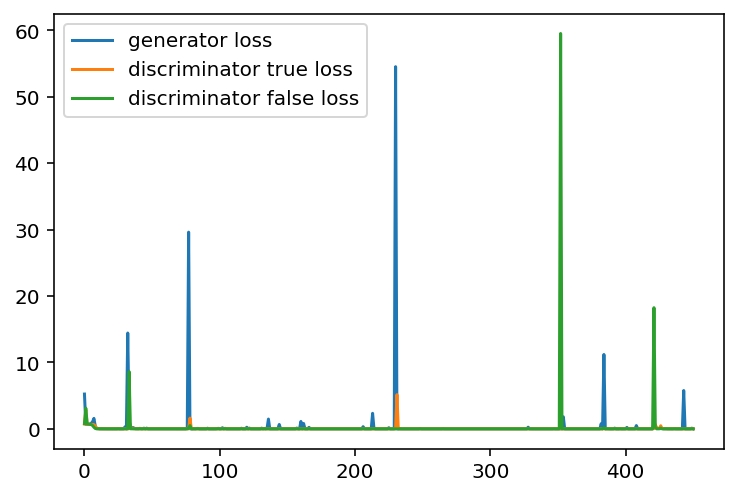

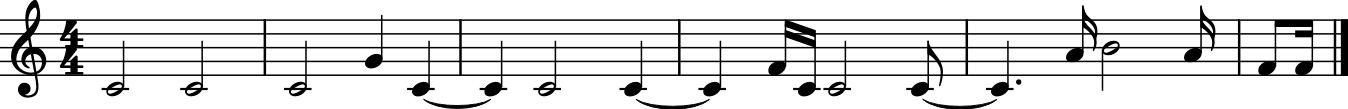

[[3.6329407e-12 3.8570430e-08 2.3764773e-12 5.0158093e-11 8.8593776e-15
  3.0964557e-06 4.5506655e-16 4.0563278e-11 5.5777268e-06 5.3035437e-11
  2.5743628e-12 3.4417434e-13 8.8923322e-09 1.0348334e-06 1.6533316e-15
  8.8583949e-12 7.7083277e-11 1.8238614e-15 1.7252290e-09 2.3875676e-12
  1.8140164e-14 1.7372283e-13 7.9911243e-14 1.7243151e-12 2.7930906e-16]]


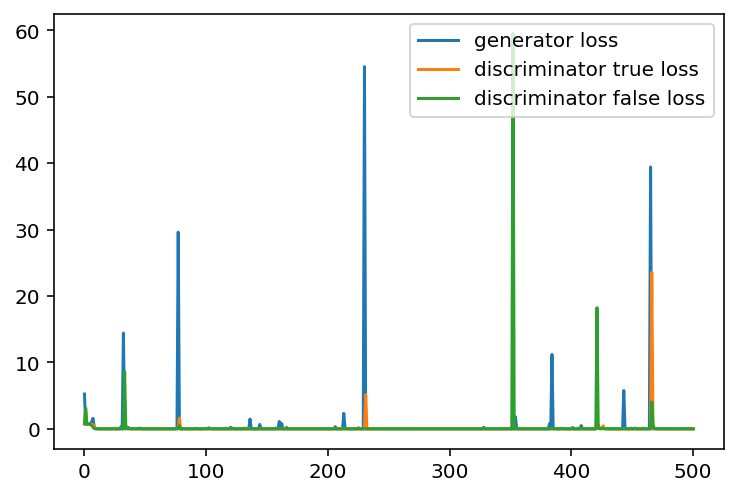

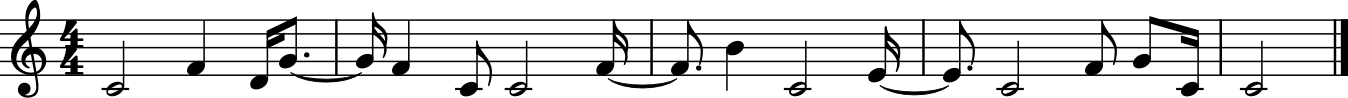

[[3.9466929e-07 1.7268337e-07 4.0963793e-10 2.1956241e-08 2.5644930e-08
  8.5659934e-08 1.2141320e-04 8.8055671e-08 3.4123983e-02 4.4286739e-06
  3.1470169e-09 2.4659419e-09 2.1929322e-05 3.9290320e-05 4.2555440e-04
  5.4605448e-10 3.1790215e-09 1.7087334e-06 6.1739527e-02 1.7429670e-04
  2.5014422e-09 7.3163811e-08 8.7761244e-08 8.6750930e-07 5.6700298e-09]]


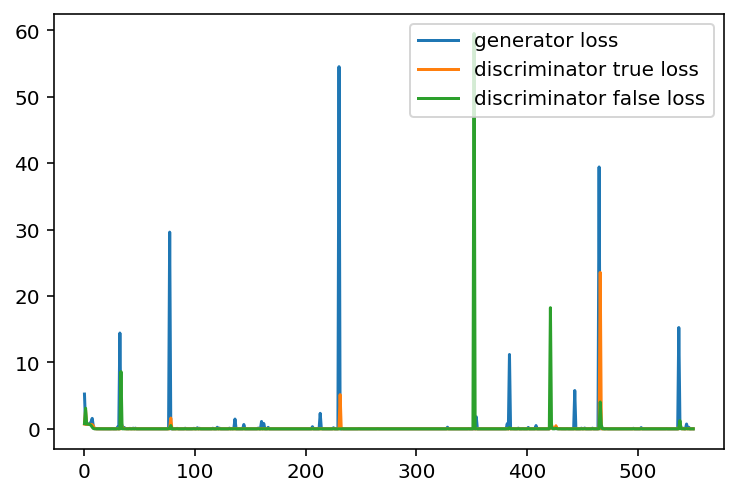

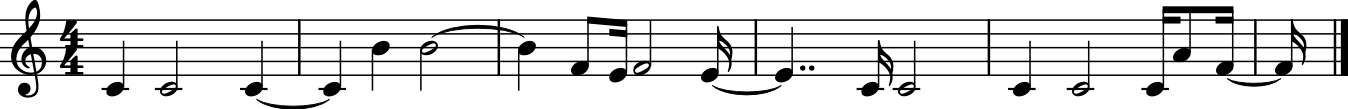

[[4.08427125e-10 7.89851604e-12 3.78586674e-06 1.91471763e-08
  1.13257320e-12 1.31147343e-10 2.36191730e-12 5.22017395e-11
  1.70911485e-09 1.74578026e-11 1.09397005e-11 1.48824134e-10
  3.79959215e-12 9.76620882e-08 2.79608692e-08 1.47458747e-11
  2.17001306e-10 1.41788387e-10 3.44739064e-11 7.87952602e-12
  1.73947656e-09 7.97997898e-13 4.02140647e-12 7.35261331e-12
  5.33644240e-10]]


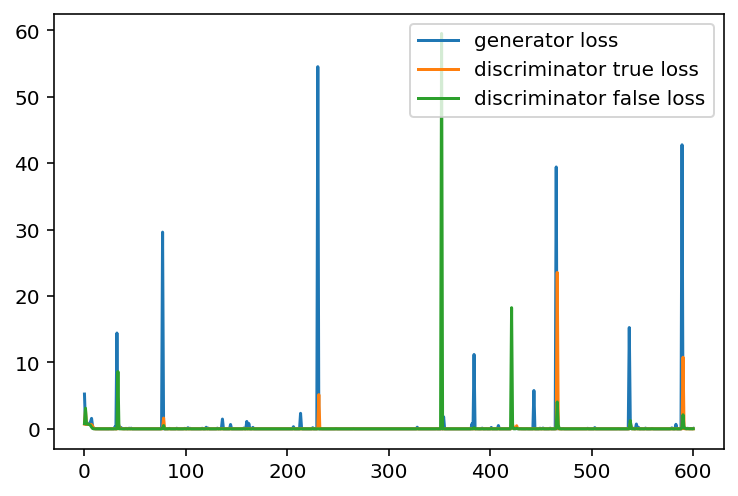

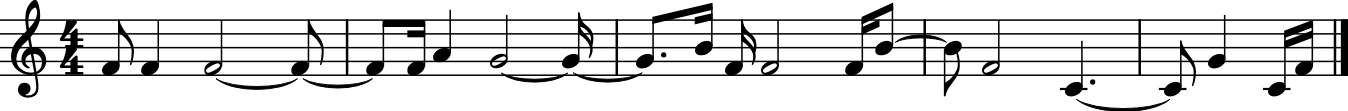

[[4.34764341e-04 6.66434644e-05 3.82577011e-04 1.66934461e-03
  1.34125030e-05 1.21108504e-04 2.56871253e-08 4.74920147e-04
  7.32193817e-04 1.57934483e-05 3.66879647e-07 1.36737128e-07
  3.82230282e-02 4.29993292e-04 2.43724952e-03 3.71951501e-05
  5.31713658e-06 2.81030930e-06 6.47643219e-06 9.00812935e-08
  8.48251943e-07 2.72632169e-05 2.47152675e-05 1.59456590e-07
  2.83996254e-04]]


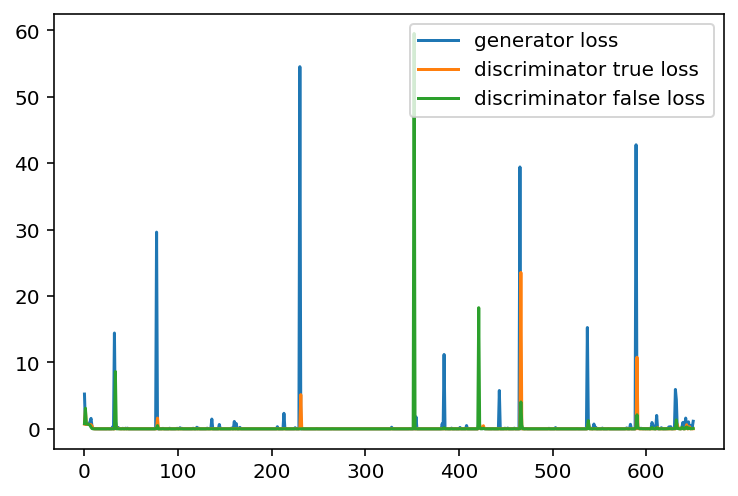

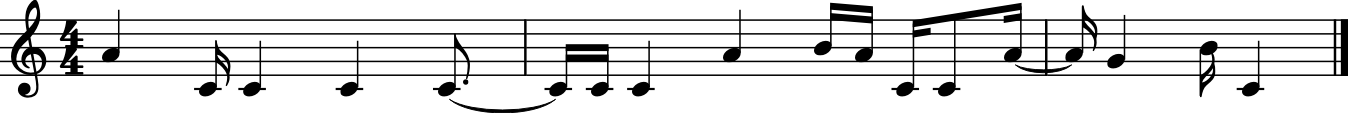

[[6.73537288e-05 1.00490295e-04 8.22402569e-07 5.60825574e-05
  1.63305401e-06 7.49502855e-04 8.78291985e-07 4.34721645e-04
  7.70287261e-06 5.49987256e-08 2.58154546e-06 1.04772917e-04
  1.32937184e-05 8.98161015e-05 1.04477906e-04 7.45941270e-06
  3.30117793e-04 1.23353857e-05 4.32623638e-04 1.13520639e-06
  6.81146616e-07 3.97677161e-03 5.59812179e-06 7.89499097e-08
  2.80811917e-04]]


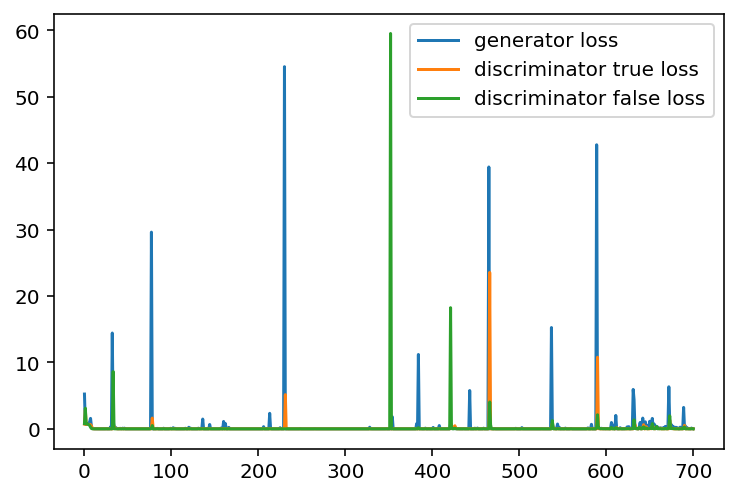

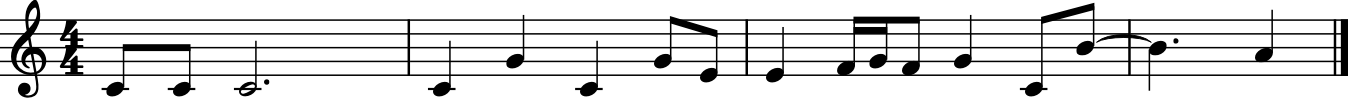

[[5.0666424e-12 1.0715714e-15 5.3853228e-12 1.9240582e-14 1.5020889e-11
  1.4760007e-14 1.4604976e-10 8.0225093e-10 1.1613674e-13 1.4450317e-12
  6.9749339e-13 3.9621845e-10 2.5170564e-11 1.3942651e-10 1.1614547e-08
  3.4019884e-10 4.2893117e-13 5.8312279e-11 1.7723770e-10 5.5994083e-06
  4.0901842e-08 4.1390524e-16 1.5373866e-08 2.3292188e-12 1.6262965e-11]]


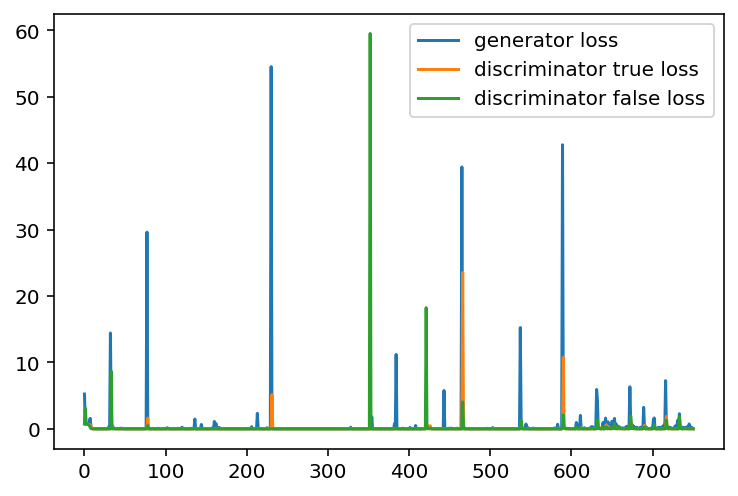

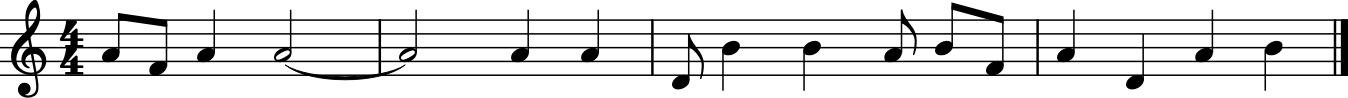

[[1.2590857e-13 1.2739677e-11 4.7780213e-10 1.5928219e-08 6.9730976e-03
  1.1359480e-05 4.9990532e-03 1.4026867e-07 2.5253373e-06 3.8639030e-03
  6.7339784e-10 1.5907820e-04 2.9800637e-07 3.6991210e-09 2.3276069e-12
  7.3778247e-05 2.2788653e-10 3.3666706e-07 7.8948403e-08 6.6344645e-09
  1.0323672e-06 8.5304433e-05 7.3333104e-06 9.6688423e-13 1.7291856e-09]]


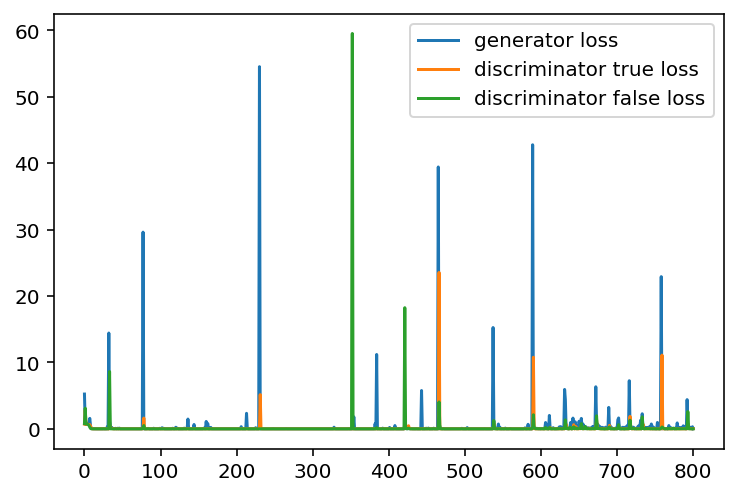

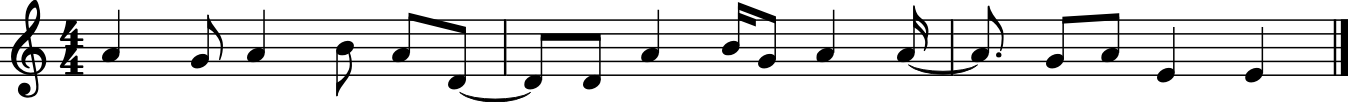

[[3.29548930e-04 3.57700701e-05 5.86620159e-02 1.12829221e-04
  2.51194200e-04 7.02432153e-05 1.47594728e-10 3.02506396e-05
  1.43312430e-02 2.16604117e-03 1.98208327e-05 9.78703702e-06
  7.43281532e-07 2.72172765e-04 7.59753675e-05 1.14253990e-03
  1.12427615e-05 1.54693879e-03 6.89464578e-05 4.35922809e-09
  1.35539576e-05 4.84142406e-03 2.62005386e-07 1.55081980e-05
  1.71041302e-03]]


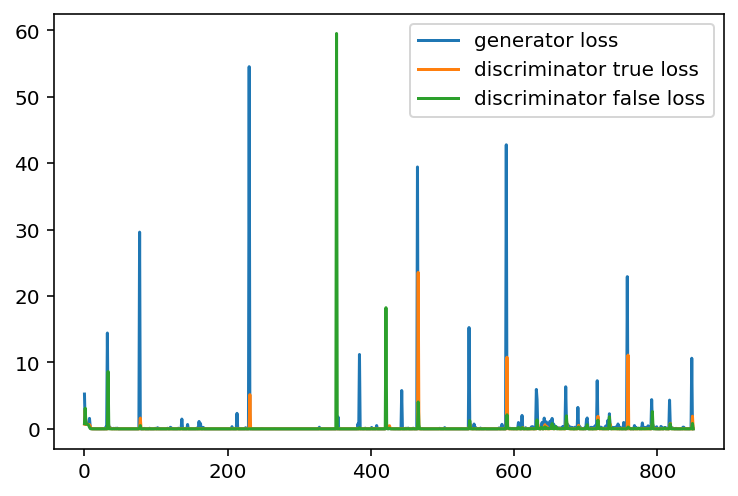

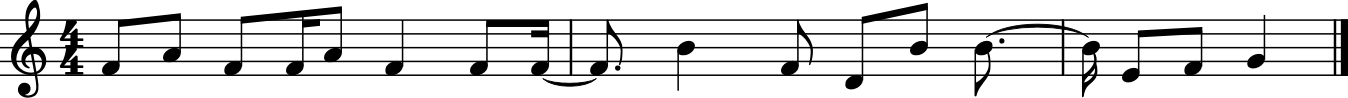

[[9.1662885e-05 1.2712673e-07 5.4338267e-03 6.6711004e-07 2.9608353e-05
  1.3622184e-07 1.9280851e-06 2.6415753e-01 1.7226824e-04 1.4572735e-02
  1.6331882e-05 4.8050788e-05 3.3612334e-05 9.0973424e-07 1.0850148e-04
  2.2938255e-02 7.5395283e-04 2.1476406e-05 4.1081524e-04 2.4010616e-03
  2.0637470e-05 2.1160281e-06 1.2509513e-04 9.0147124e-04 6.0279436e-02]]


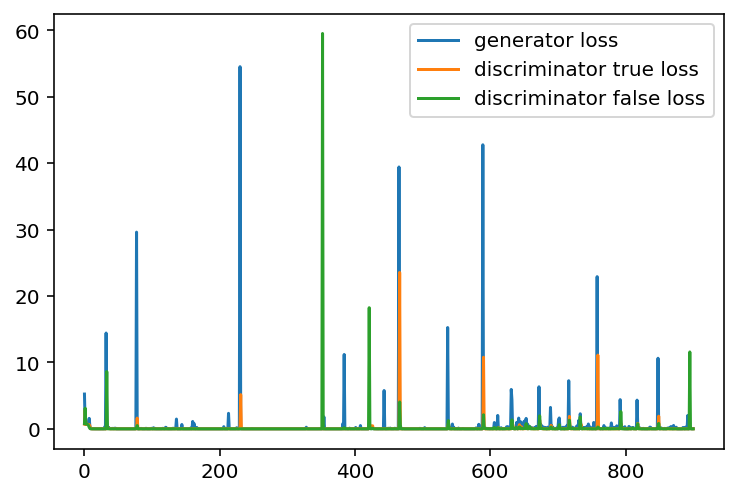

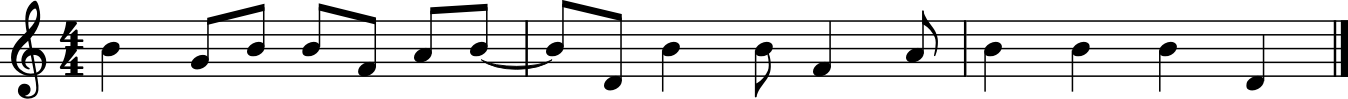

[[2.3323865e-10 8.4911900e-10 4.3943589e-07 7.2308796e-07 1.2548070e-08
  1.5020503e-06 7.1278081e-09 7.4329758e-11 3.5671867e-13 3.1937231e-09
  5.2249165e-06 1.3161848e-03 8.7150476e-10 1.0694516e-04 6.5397813e-05
  4.6738910e-07 3.1745687e-06 7.7244704e-06 1.1823956e-07 2.4761716e-06
  2.3242303e-06 2.2981172e-04 3.1708004e-07 2.2891152e-05 1.4880395e-14]]


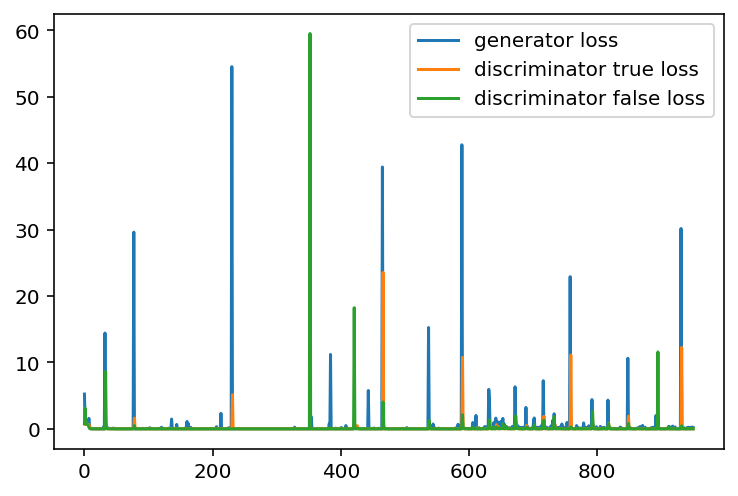

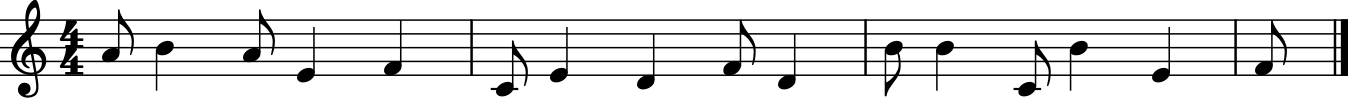

[[2.6412447e-08 1.1988711e-13 3.7764078e-08 8.5999289e-12 2.5641359e-08
  7.5820055e-05 4.9324150e-08 3.0299290e-08 1.3700127e-10 1.2874587e-15
  2.1973492e-09 2.3237201e-13 1.3373647e-11 4.8132667e-09 2.8185166e-08
  4.8377117e-13 5.8680335e-08 7.2556517e-08 9.6212240e-11 6.9039606e-04
  4.2615509e-05 5.0978847e-16 5.6520836e-13 1.7381972e-04 6.5711078e-12]]


In [13]:
nlen=100
n= 1
from IPython.display import clear_output
def train_discriminator(x_train_notes, x_train_durations,  batch_size,  notes_dict, durations_dict):
    valid =  1* np.ones((batch_size,1))
    fake =  0* np.ones((batch_size,1))
    
 # TRAIN ON REAL MUSIC
    for i in range (n):
        range_notes = len(x_train_notes)
        #range_notes = 25000
        idx = np.random.randint(0, range_notes, batch_size)
        true_notes = x_train_notes[idx]
        true_durations = x_train_durations[idx]
        logits1 = discriminator.train_on_batch([true_notes, true_durations], valid)
    
    
 # TRAIN ON GENERATED MUSIC
    noise = np.random.randint(0, nlen, size=(batch_size, length, noiselen))
    [gen_notes, gen_durations]= generator.predict(noise)
    #gen_durations =  0.8*one_hot(np.argmax(gen_durations, axis=2), 12)
    #gen_notes =  0.8*one_hot(np.argmax(gen_notes, axis=2), 84)
    logits2 = discriminator.train_on_batch([gen_notes, gen_durations], fake)
    
    return logits1, logits2
    
def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.randint(0, nlen, size=(batch_size, length, noiselen))
    logits = model.train_on_batch(noise, valid)
    return logits
        
        






result_notes = np.empty
result_durations = np.empty

fig = plt.subplots()
fig = plt.gcf()
plt.show(block=False)
accs = 0



epochs = 1000
batch_size = 25

i=0
for epoch in range(epochs): 
    discriminator.trainable = True
    [logits1_dis, logits2_dis] = train_discriminator(x_train_notes, x_train_durations, batch_size,  notes_dict, durations_dict)
    discriminator.trainable = False
    logits_gen = train_generator(batch_size)
    
    ydat1.append(logits_gen[0])
    ydat2.append(logits1_dis[0])
    ydat3.append(logits2_dis[0])
    xdat.append(count)
    count = count+1
    if epoch %  50 == 0:

        #clear_output(wait=True)
        plt.plot(xdat,ydat1, label = "generator loss")
        plt.plot(xdat,ydat2, label = "discriminator true loss")
        plt.plot(xdat,ydat3, label = "discriminator false loss")
        plt.legend()
        fig.canvas.draw()
        plt.pause(0.5)
        
        noise = np.random.randint(0, nlen, size=(1, length, noiselen))
        [predictions_notes, predictions_durations] = generator.predict(noise)
#print(predictions_notes[0][0])
        pred_notes = np.argmax(predictions_notes, axis=2)
        pred_durations = np.argmax(predictions_durations, axis=2)

#pred_notes = np.argmax(x_train_notes[22000], axis=1)
#pred_durations = np.argmax(x_train_durations[22000], axis=1)
        pred_notes = np.reshape(pred_notes, length)
        pred_durations = np.reshape(pred_durations, length)
        pred_notes = [int_notes_dict[int(x)] for x in pred_notes]
        pred_durations = [int_durations_dict[int(x)] for x in pred_durations]

        midi_stream = stream.Stream()

#offset = 0

        for item1, item2 in zip(pred_notes, pred_durations):
            pattern = item1[0]
            duration = item2
            new_note = note.Note(pattern,  quarterLength=duration)      
            midi_stream.append(new_note)

        midi_stream.show()  
        midi_stream.show('midi') 
        
        
        
        noise = np.random.randint(0, nlen, size=(batch_size, length, noiselen))
        [gen_notes, gen_durations]= generator.predict(noise)
        #gen_durations =  0.8*one_hot(np.argmax(gen_durations, axis=2), 12)
        #gen_notes =  0.8*one_hot(np.argmax(gen_notes, axis=2), 84)
        logits = discriminator.predict([gen_notes, gen_durations])
        print(logits.T)

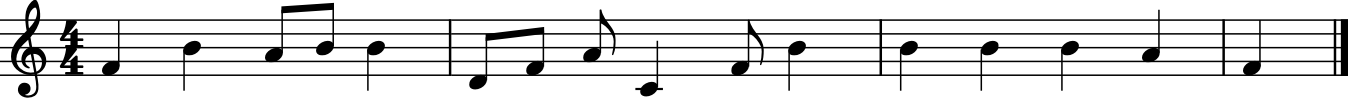

In [20]:
#generate music stream
noise = np.random.randint(0, nlen, size=(1, length, noiselen))
[predictions_notes, predictions_durations] = generator.predict(noise)
pred_notes = np.argmax(predictions_notes, axis=2)
pred_durations = np.argmax(predictions_durations, axis=2)


pred_notes = np.reshape(pred_notes, length)
pred_durations = np.reshape(pred_durations, length)
pred_notes = [int_notes_dict[int(x)] for x in pred_notes]
pred_durations = [int_durations_dict[int(x)] for x in pred_durations]

midi_stream = stream.Stream()

#offset = 0

for item1, item2 in zip(pred_notes, pred_durations):
    pattern = item1[0]
    duration = item2
    new_note = note.Note(pattern,  quarterLength=duration)      
    midi_stream.append(new_note)

midi_stream.show()   
midi_stream.show('midi')  

In [21]:
#fp = midi_stream.write("midi", "blah3.mid")

#model.save('model')
#discriminator.save('discriminator')
#generator.save('generator')

In [16]:
noise = np.random.randint(0, nlen, size=(1, length, noiselen))
[predictions_notes, predictions_durations] = generator.predict(noise)
predictions_durations = one_hot(np.argmax(predictions_durations, axis=2), 12)
predictions_notes = one_hot(np.argmax(predictions_notes, axis=2), 84)
discriminator.predict([predictions_notes, predictions_durations])

array([[0.9949366]], dtype=float32)

In [17]:
#show random training data
for i in range(5):
    value = np.random.randint(0,len(x_train_notes))
    print(value)
    test1 = x_train_notes[value]
    test1 = np.argmax(test1, axis=1)
    test1 = np.reshape(test1, length)
    test1 = [int_notes_dict[int(x)] for x in test1]

    midi_stream = stream.Stream()
    for item1 in zip(test1):
        pattern = item1[0]
    #duration = item2
        new_note = note.Note(pattern,  quarterLength=1)      
        midi_stream.append(new_note)
    midi_stream.show()   

In [18]:
#check if music stream with only the same notes are in training data, and if so, where
x_train_notes1 = np.argmax(x_train_notes, axis=2)
for i in range(x_train_notes1.shape[0]):
    if np.all(x_train_notes1[i]==x_train_notes1[i][0]):
        print('Row: ', i)
